In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

GRT_QUERY_ENDPOINT = "https://api.thegraph.com/subgraphs/name/convex-community/volume-fantom-test"

def grt_query(query):
    r = requests.post(GRT_QUERY_ENDPOINT, json={'query': query})
    return r.json()['data']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
fee_query = """
{ pools(first: 1000) {
  isV2
  id
  name
  dailyPoolSnapshots(first: 1000 orderBy: timestamp orderDirection: desc) {
    timestamp
    adminFeesUSD
    lpFeesUSD
    totalDailyFeesUSD
    eventFeesUSD
    baseApr
    tvl
  }
}
}
"""

In [3]:
data = grt_query(fee_query)['pools']
df = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df['totalDailyFeesUSD'] = df['totalDailyFeesUSD'].astype(float)
df['eventFeesUSD'] = df['eventFeesUSD'].astype(float) * 2
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
df = df.sort_values('timestamp', ascending=True)
df

,isV2,id,name,timestamp,adminFeesUSD,lpFeesUSD,totalDailyFeesUSD,eventFeesUSD,baseApr,tvl
2846,False,0x3ef6a01a0f81d6046290f3e2a8c5b843e738e604,Curve.fi WBTC/renBTC,2021-09-15,0,0,0.00,0.00,0,746061999.3737567051744536333606454
4717,False,0x92d5ebf3593a92888c25c0abef126583d4b5312e,Curve.fi fUSDT/DAI/USDC,2021-09-15,0,0,0.00,0.00,0,112296796.991341
1807,False,0x27e611fd27b276acbd5ffd632e5eaebec9761e40,Curve.fi DAI/USDC,2021-09-15,0,0,0.00,0.00,0,157079756.479740671524196489
1806,False,0x27e611fd27b276acbd5ffd632e5eaebec9761e40,Curve.fi DAI/USDC,2021-09-16,1245.796728686016552605875416171606,1245.796728686016552605875416171606,2491.59,0.00,0.000007719849532783787759067728429417837,161375778.5557227869508008266105339
2845,False,0x3ef6a01a0f81d6046290f3e2a8c5b843e738e604,Curve.fi WBTC/renBTC,2021-09-16,1760.081873511934435953066393302096,1760.081873511934435953066393302096,3520.16,0.00,0.000002331397254561511300767662891080719,754947218.9127074613301669761197279
...,...,...,...,...,...,...,...,...,...,...
708,False,0x138ccfe5d99c139b9c4918ace02a082ca67693bb,Curve.fi Factory USD Metapool: Creditum,2022-03-14,0,0,0.00,0.00,0,99.88182158145325107272417510893688
4168,False,0x84f21b7ceb64906320e2b62cf73ff03dcfd137dc,Curve.fi Factory Plain Pool: MAI3Pool,2022-03-14,0,0,0.00,0.00,0,9.042150544595423710696495051337229
7297,False,0xd5b51ba080f815446646a61039fbbfef5a12a4cf,Curve.fi Factory USD Metapool: MIM1 Pool,2022-03-14,0.0001368479088917474592131885181522123,0.0001368479088917474592131885181522123,0.00,0.00,0.000001044132749918950523754790149583902,131.0637070835773554915005424637887
4066,False,0x83a503780983bbabd6acab577fba2c5a3dcaa57f,Curve.fi Factory USD Metapool: usdp+2pool,2022-03-14,0.00002065782177219784925396476280641224,0.00002065782177219784925396476280641224,0.00,0.00,0.000005696775353940764820024035956046893,3.626230716278416493633405754868251


<AxesSubplot:xlabel='timestamp'>

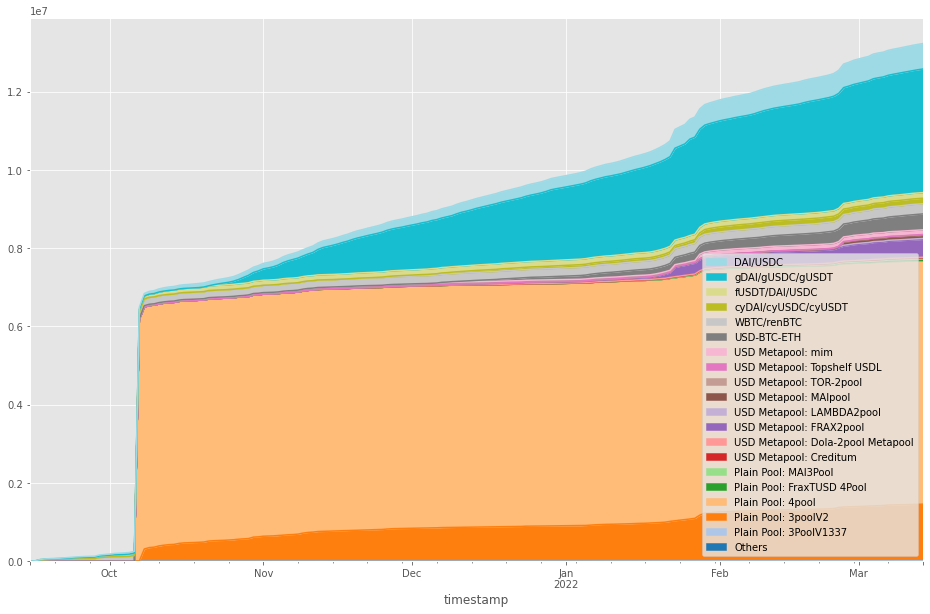

In [4]:
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data = df[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name')
top_performers = chart_data.mean().sort_values(ascending=False)[:19].index.tolist()
df_others = df.copy()
df_others['name'] = df_others['name'].apply(lambda x: x if x in top_performers else 'Others')
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data_others = df_others[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name')
chart_data_others['Others'] = df_others[df_others['name'] == 'Others'][['timestamp', 'cumulativeDailyFeesUSD']].groupby('timestamp').sum()['cumulativeDailyFeesUSD']
chart_data_others.columns = [s.replace('Curve.fi Factory ', '').replace('Curve.fi ', '').replace('Curve ', '') for s in chart_data_others.columns]
cols = chart_data_others.columns.tolist()
chart_data_others[([cols[-1], *cols[1:-1], cols[0]])].plot.area(figsize=(16, 10), legend='reverse', colormap="tab20")

In [5]:
WEEK = 3600 * 24 * 7
df_week = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df_week['totalDailyFeesUSD'] = df_week['totalDailyFeesUSD'].astype(float)
df_week['timestamp'] = df_week['timestamp'].apply(lambda x: ((int(x) // WEEK) * WEEK))
df_week['timestamp'] = pd.to_datetime(df_week['timestamp'],unit='s')
df_week = df_week.sort_values('timestamp', ascending=True)
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum()

,totalDailyFeesUSD
timestamp,
2021-09-09,0.00
2021-09-16,87743.32
2021-09-23,72211.48
2021-09-30,93687.15
2021-10-07,6756117.65
2021-10-14,101258.62
2021-10-21,212990.47
2021-10-28,344414.67
2021-11-04,342754.21
